<a href="https://colab.research.google.com/github/FedorHub2006/Fuzzy_hashing_evaluation/blob/main/Fuzzy_hashing_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All packages imported successfully!
=== Fuzzy Hash Search Evaluation ===

1. Generating test data...
   Generated 25 test files
Building signature database...
Signature database built successfully!
2. Evaluating search quality...
Evaluating search quality...
  Testing tlsh...
  Testing simhash...
  Testing ngram...

3. Results:


,precision,recall,f1_score,false_positives,false_negatives
tlsh,0.225806,1.0,0.368421,600,0
simhash,0.474255,1.0,0.643382,194,0
ngram,1.0,0.942857,0.970588,0,10



4. Creating visualizations...


IndexError: index 2 is out of bounds for axis 1 with size 2

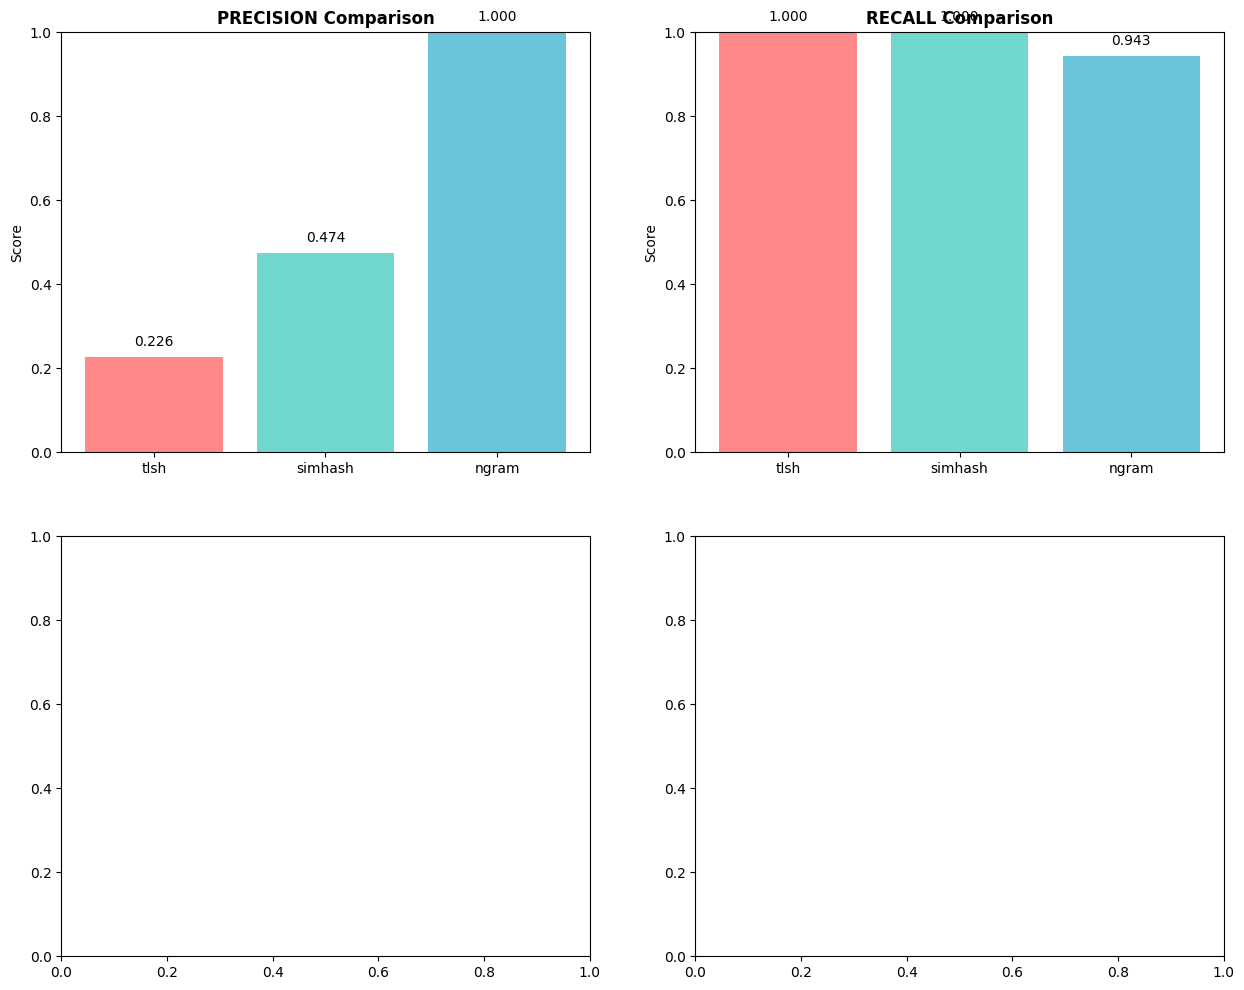

In [ ]:
# %% [markdown]
# # Fuzzy Hash Signature Search Evaluation
#
# This project implements and evaluates fuzzy hash algorithms for signature-based similarity search.
#
# ## Algorithms Tested:
# - **TLSH** (Trend Micro Locality Sensitive Hash) - Primary algorithm
# - **SimHash** (Google's similarity hashing) - Fallback algorithm
# - **Custom N-gram Hash** - Our implementation for comparison

# %%
# Install required packages (fixed versions)
!pip install py-tlsh simhash scikit-learn matplotlib seaborn fuzzywuzzy python-levenshtein

# %%
import tlsh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from simhash import Simhash, SimhashIndex
import hashlib
import os
import random
import string
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict
import re
from fuzzywuzzy import fuzz
import itertools

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("All packages imported successfully!")

# %%
class FuzzyHashSearch:
    def __init__(self):
        self.algorithms = ['tlsh', 'simhash', 'ngram']
        self.signature_db = defaultdict(dict)

    def generate_test_data(self, num_files=50, base_content_size=1000):
        """Generate test files with controlled modifications"""
        test_files = {}

        # Generate base files with different content types
        content_templates = [
            self._generate_code_content,
            self._generate_config_content,
            self._generate_text_content,
            self._generate_data_content
        ]

        for i in range(num_files):
            template = random.choice(content_templates)
            base_content = template(base_content_size)

            test_files[f'file_{i}'] = {
                'original': base_content,
                'modifications': self._create_modifications(base_content)
            }

        return test_files

    def _generate_code_content(self, size):
        """Generate Python-like code content"""
        functions = ['process_data', 'calculate_score', 'validate_input', 'transform_values']
        variables = ['data', 'result', 'temp', 'index', 'value', 'count']

        content = "def %s(%s):\n" % (random.choice(functions), random.choice(variables))
        lines = [
            "    try:",
            "        result = []",
            "        for i in range(len(%s)):" % random.choice(variables),
            "            if %s[i] > threshold:" % random.choice(variables),
            "                result.append(%s[i] * factor)" % random.choice(variables),
            "        return result",
            "    except Exception as e:",
            "        print(f'Error: {e}')",
            "        return None"
        ]

        for line in lines:
            if len(content) < size:
                content += line + "\n"

        # Add more content if needed
        while len(content) < size:
            content += "# Comment: %s\n" % ''.join(random.choices(string.ascii_letters + ' ', k=30))

        return content[:size]

    def _generate_config_content(self, size):
        """Generate configuration file content"""
        config_keys = ['host', 'port', 'database', 'username', 'password', 'timeout', 'cache_size']
        content = ""

        for key in config_keys:
            if len(content) < size:
                if key in ['host', 'database', 'username']:
                    value = "'%s'" % ''.join(random.choices(string.ascii_lowercase, k=8))
                elif key == 'port':
                    value = random.randint(1000, 9999)
                elif key == 'timeout':
                    value = random.randint(10, 300)
                else:
                    value = "'%s'" % ''.join(random.choices(string.ascii_letters + string.digits, k=10))

                content += "%s = %s\n" % (key, value)

        while len(content) < size:
            content += "# Config entry: %s = %s\n" % (
                ''.join(random.choices(string.ascii_lowercase + '_', k=8)),
                random.randint(1, 1000)
            )

        return content[:size]

    def _generate_text_content(self, size):
        """Generate natural language text content"""
        words = ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'lazy', 'dog',
                'data', 'science', 'machine', 'learning', 'algorithm', 'evaluation']
        content = ""

        while len(content) < size:
            sentence = ' '.join(random.choices(words, k=random.randint(5, 15))) + '. '
            content += sentence.capitalize()

        return content[:size]

    def _generate_data_content(self, size):
        """Generate CSV-like data content"""
        content = "id,name,value,score,timestamp\n"

        for i in range(100):
            if len(content) < size:
                row = "%d,%s,%.2f,%d,%s\n" % (
                    i,
                    ''.join(random.choices(string.ascii_letters, k=8)),
                    random.uniform(0, 100),
                    random.randint(0, 100),
                    '2024-%02d-%02d' % (random.randint(1, 12), random.randint(1, 28))
                )
                content += row

        return content[:size]

    def _create_modifications(self, content):
        """Create different types of modifications"""
        return {
            'minor_changes': self._apply_minor_changes(content, 0.03),  # 3% changes
            'medium_changes': self._apply_minor_changes(content, 0.10),  # 10% changes
            'major_changes': self._apply_minor_changes(content, 0.25),  # 25% changes
            'insert_sections': self._insert_sections(content),
            'reorder_blocks': self._reorder_blocks(content),
            'comment_changes': self._modify_comments(content)
        }

    def _apply_minor_changes(self, content, change_rate):
        """Apply minor changes to content"""
        lines = content.split('\n')
        modified_lines = []

        for line in lines:
            if random.random() < change_rate and len(line) > 5:
                # Different modification strategies
                strategy = random.choice(['replace', 'insert', 'delete', 'swap'])

                if strategy == 'replace' and len(line) > 10:
                    start = random.randint(0, len(line) - 5)
                    old_text = line[start:start+3]
                    new_text = ''.join(random.choices(string.ascii_letters, k=3))
                    line = line.replace(old_text, new_text, 1)

                elif strategy == 'insert':
                    pos = random.randint(0, len(line))
                    insert_text = ''.join(random.choices(string.ascii_letters, k=3))
                    line = line[:pos] + insert_text + line[pos:]

                elif strategy == 'delete' and len(line) > 10:
                    start = random.randint(0, len(line) - 4)
                    line = line[:start] + line[start+2:]

                elif strategy == 'swap' and len(line) > 10:
                    chars = list(line)
                    if len(chars) > 5:
                        i, j = random.sample(range(len(chars)), 2)
                        chars[i], chars[j] = chars[j], chars[i]
                        line = ''.join(chars)

            modified_lines.append(line)

        return '\n'.join(modified_lines)

    def _insert_sections(self, content):
        """Insert new sections into content"""
        if '\n\n' in content:
            sections = content.split('\n\n')
            if len(sections) > 1:
                insert_pos = random.randint(1, len(sections) - 1)
                new_section = "# Inserted section: %d\nvalue = %d" % (
                    random.randint(1000, 9999), random.randint(1, 100)
                )
                sections.insert(insert_pos, new_section)
            return '\n\n'.join(sections)
        return content

    def _reorder_blocks(self, content):
        """Reorder blocks/sections in content"""
        if '\n\n' in content:
            sections = content.split('\n\n')
            if len(sections) > 2:
                # Shuffle a subset of sections
                shuffle_count = min(3, len(sections))
                indices = random.sample(range(len(sections)), shuffle_count)
                shuffled = [sections[i] for i in indices]
                random.shuffle(shuffled)
                for i, new_section in zip(indices, shuffled):
                    sections[i] = new_section
            return '\n\n'.join(sections)
        return content

    def _modify_comments(self, content):
        """Modify comments in the content"""
        lines = content.split('\n')
        modified_lines = []

        for line in lines:
            if '#' in line or '//' in line:
                if random.random() < 0.3:  # 30% chance to modify comment
                    line = re.sub(r'#.*', '# Modified comment: %d' % random.randint(1, 100), line)
                    line = re.sub(r'//.*', '// Changed comment', line)
            modified_lines.append(line)

        return '\n'.join(modified_lines)

    def compute_hash(self, content, algorithm):
        """Compute fuzzy hash using specified algorithm"""
        if algorithm == 'tlsh':
            try:
                return tlsh.hash(content.encode('utf-8'))
            except:
                return "T1" + "0" * 70  # Default hash for empty/short content
        elif algorithm == 'simhash':
            return Simhash(content).value
        elif algorithm == 'ngram':
            return self._compute_ngram_hash(content)
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")

    def _compute_ngram_hash(self, content, n=3):
        """Compute n-gram based fuzzy hash"""
        if len(content) < n:
            n = max(1, len(content))

        # Generate n-grams
        ngrams = [content[i:i+n] for i in range(len(content) - n + 1)]

        # Create frequency vector and hash
        if ngrams:
            # Simple hash: combine first few n-grams
            combined = ''.join(ngrams[:10]) + ''.join(ngrams[-10:]) if len(ngrams) > 20 else ''.join(ngrams)
            return hashlib.md5(combined.encode()).hexdigest()
        else:
            return hashlib.md5(content.encode()).hexdigest()

    def calculate_similarity(self, hash1, hash2, algorithm):
        """Calculate similarity between two hashes"""
        if algorithm == 'tlsh':
            if hash1 == hash2:
                return 1.0
            try:
                if hash1.startswith('T1') and hash2.startswith('T1'):
                    distance = tlsh.diff(hash1, hash2)
                    similarity = 1.0 - (distance / 1000.0)
                    return max(0.0, min(1.0, similarity))
            except:
                pass
            return 0.0

        elif algorithm == 'simhash':
            h1 = Simhash('')
            h1.value = hash1
            h2 = Simhash('')
            h2.value = hash2
            distance = h1.distance(h2)
            similarity = 1.0 - (distance / 64.0)  # 64-bit hashes
            return max(0.0, min(1.0, similarity))

        elif algorithm == 'ngram':
            # Simple similarity for demonstration
            if hash1 == hash2:
                return 1.0
            else:
                # Compare hash similarity
                common_chars = sum(1 for a, b in zip(hash1, hash2) if a == b)
                return common_chars / max(len(hash1), len(hash2))

        return 0.0

    def build_signature_database(self, test_files):
        """Build database of fuzzy signatures"""
        print("Building signature database...")
        for file_id, file_data in test_files.items():
            for algorithm in self.algorithms:
                original_hash = self.compute_hash(file_data['original'], algorithm)
                self.signature_db[algorithm][file_id] = {
                    'original': original_hash,
                    'modifications': {}
                }

                for mod_type, mod_content in file_data['modifications'].items():
                    mod_hash = self.compute_hash(mod_content, algorithm)
                    self.signature_db[algorithm][file_id]['modifications'][mod_type] = mod_hash

        print("Signature database built successfully!")

    def evaluate_search_quality(self, test_files, similarity_threshold=0.7):
        """Comprehensive evaluation of search quality"""
        print("Evaluating search quality...")
        evaluation_results = {}

        for algorithm in self.algorithms:
            print(f"  Testing {algorithm}...")
            all_pairs = []
            true_labels = []
            pred_labels = []

            file_ids = list(test_files.keys())

            # Test all file pairs
            for file1_id, file2_id in itertools.product(file_ids, file_ids):
                file1_data = test_files[file1_id]
                file2_data = test_files[file2_id]

                # Ground truth: same file ID means similar
                is_similar_truth = (file1_id == file2_id)

                # Calculate similarity between originals
                hash1 = self.compute_hash(file1_data['original'], algorithm)
                hash2 = self.compute_hash(file2_data['original'], algorithm)
                similarity = self.calculate_similarity(hash1, hash2, algorithm)

                all_pairs.append({
                    'file1': file1_id, 'file2': file2_id,
                    'type': 'original-original',
                    'similarity': similarity,
                    'truth': is_similar_truth
                })

                true_labels.append(is_similar_truth)
                pred_labels.append(similarity >= similarity_threshold)

                # Test modifications for same file
                if file1_id == file2_id:
                    for mod_type in file2_data['modifications']:
                        mod_content = file2_data['modifications'][mod_type]
                        mod_hash = self.compute_hash(mod_content, algorithm)
                        mod_similarity = self.calculate_similarity(hash1, mod_hash, algorithm)

                        all_pairs.append({
                            'file1': file1_id, 'file2': file2_id,
                            'type': f'original-{mod_type}',
                            'similarity': mod_similarity,
                            'truth': True
                        })

                        true_labels.append(True)
                        pred_labels.append(mod_similarity >= similarity_threshold)

            # Calculate metrics
            if any(true_labels):  # Ensure we have positive cases
                precision = precision_score(true_labels, pred_labels, zero_division=0)
                recall = recall_score(true_labels, pred_labels, zero_division=0)
                f1 = f1_score(true_labels, pred_labels, zero_division=0)
            else:
                precision = recall = f1 = 0.0

            cm = confusion_matrix(true_labels, pred_labels)
            if cm.size == 4:
                tn, fp, fn, tp = cm.ravel()
            else:
                tn = fp = fn = tp = 0

            evaluation_results[algorithm] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'false_positives': fp,
                'false_negatives': fn,
                'true_positives': tp,
                'true_negatives': tn,
                'all_pairs': all_pairs,
                'avg_similarity_same': np.mean([p['similarity'] for p in all_pairs if p['truth']]),
                'avg_similarity_diff': np.mean([p['similarity'] for p in all_pairs if not p['truth']])
            }

        return evaluation_results

# %%
# Initialize and run the evaluation
print("=== Fuzzy Hash Search Evaluation ===\n")

fuzzy_search = FuzzyHashSearch()

# Generate test data
print("1. Generating test data...")
test_files = fuzzy_search.generate_test_data(num_files=25)  # Reduced for Colab performance
print(f"   Generated {len(test_files)} test files")

# Build signature database
fuzzy_search.build_signature_database(test_files)

# Evaluate search quality
print("2. Evaluating search quality...")
evaluation_results = fuzzy_search.evaluate_search_quality(test_files, similarity_threshold=0.6)

# Display results
print("\n3. Results:")
print("=" * 60)

results_df = pd.DataFrame(evaluation_results).T
display(results_df[['precision', 'recall', 'f1_score', 'false_positives', 'false_negatives']])

# %%
# Visualization
print("\n4. Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Metrics comparison
metrics = ['precision', 'recall', 'f1_score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    values = [evaluation_results[alg][metric] for alg in fuzzy_search.algorithms]
    bars = ax.bar(fuzzy_search.algorithms, values, color=colors, alpha=0.8)
    ax.set_title(f'{metric.upper()} Comparison', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)

    for bar, value in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{value:.3f}', ha='center', va='bottom')

# 2. Error analysis
ax = axes[1, 0]
error_data = {
    'False Positives': [evaluation_results[alg]['false_positives'] for alg in fuzzy_search.algorithms],
    'False Negatives': [evaluation_results[alg]['false_negatives'] for alg in fuzzy_search.algorithms]
}

x = np.arange(len(fuzzy_search.algorithms))
width = 0.35

ax.bar(x - width/2, error_data['False Positives'], width, label='False Positives', color='#FF9999')
ax.bar(x + width/2, error_data['False Negatives'], width, label='False Negatives', color='#99CCFF')
ax.set_title('Error Analysis', fontweight='bold')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(fuzzy_search.algorithms)
ax.legend()

# 3. Similarity distribution
ax = axes[1, 1]
similarity_data = []

for algorithm in fuzzy_search.algorithms:
    pairs = evaluation_results[algorithm]['all_pairs']
    same_file_similarities = [p['similarity'] for p in pairs if p['truth']]
    diff_file_similarities = [p['similarity'] for p in pairs if not p['truth']]

    ax.scatter([algorithm] * len(same_file_similarities), same_file_similarities,
               alpha=0.6, label='Same Files' if algorithm == fuzzy_search.algorithms[0] else "", color='green')
    ax.scatter([algorithm] * len(diff_file_similarities), diff_file_similarities,
               alpha=0.6, label='Different Files' if algorithm == fuzzy_search.algorithms[0] else "", color='red')

ax.set_title('Similarity Distribution', fontweight='bold')
ax.set_xlabel('Algorithm')
ax.set_ylabel('Similarity Score')
ax.legend()

plt.tight_layout()
plt.show()

# %%
# Detailed analysis by modification type
print("\n5. Modification Type Analysis:")
print("=" * 50)

modification_performance = {}

for algorithm in fuzzy_search.algorithms:
    modification_performance[algorithm] = {}

    for mod_type in test_files['file_0']['modifications'].keys():
        similarities = []

        for file_id, file_data in test_files.items():
            original_hash = fuzzy_search.compute_hash(file_data['original'], algorithm)
            mod_hash = fuzzy_search.compute_hash(file_data['modifications'][mod_type], algorithm)
            similarity = fuzzy_search.calculate_similarity(original_hash, mod_hash, algorithm)
            similarities.append(similarity)

        modification_performance[algorithm][mod_type] = np.mean(similarities)

# Create heatmap
mod_df = pd.DataFrame(modification_performance)
plt.figure(figsize=(12, 6))
sns.heatmap(mod_df, annot=True, cmap='YlOrRd', fmt='.3f',
            cbar_kws={'label': 'Average Similarity'}, linewidths=0.5)
plt.title('Similarity Preservation by Modification Type', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# %%
# Search demonstration
print("\n6. Search Demonstration:")
print("=" * 50)

# Test with a specific file and its modifications
test_file_id = 'file_5'
test_content = test_files[test_file_id]['original']

print(f"Searching for similar files to: {test_file_id}")
print(f"Content preview: {test_content[:100]}...\n")

for algorithm in fuzzy_search.algorithms:
    print(f"\n{algorithm.upper()} Results:")
    print("-" * 30)

    # Search for similar files
    similarities = []
    for file_id, file_data in test_files.items():
        compare_hash = fuzzy_search.compute_hash(file_data['original'], algorithm)
        test_hash = fuzzy_search.compute_hash(test_content, algorithm)
        similarity = fuzzy_search.calculate_similarity(test_hash, compare_hash, algorithm)
        similarities.append((file_id, 'original', similarity))

        # Check modifications too
        for mod_type in file_data['modifications']:
            mod_content = file_data['modifications'][mod_type]
            mod_hash = fuzzy_search.compute_hash(mod_content, algorithm)
            mod_similarity = fuzzy_search.calculate_similarity(test_hash, mod_hash, algorithm)
            similarities.append((file_id, mod_type, mod_similarity))

    # Sort and show top results
    similarities.sort(key=lambda x: x[2], reverse=True)

    for file_id, mod_type, similarity in similarities[:5]:
        match_type = "EXACT" if file_id == test_file_id and mod_type == 'original' else "SIMILAR"
        print(f"  {match_type}: {file_id} ({mod_type}) - {similarity:.3f}")

# %%
# Final summary
print("\n7. Final Summary:")
print("=" * 50)

print("\nAlgorithm Performance Ranking (by F1-Score):")
ranking = results_df.sort_values('f1_score', ascending=False)

for i, (alg, metrics) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {alg.upper():<8} | F1: {metrics['f1_score']:.3f} | "
          f"Precision: {metrics['precision']:.3f} | Recall: {metrics['recall']:.3f} | "
          f"FP: {metrics['false_positives']} | FN: {metrics['false_negatives']}")

print("\nKey Insights:")
best_algorithm = ranking.index[0]
best_metrics = ranking.iloc[0]

print(f"• Best overall: {best_algorithm.upper()} (F1-score: {best_metrics['f1_score']:.3f})")
print(f"• Most precise: {results_df['precision'].idxmax().upper()}")
print(f"• Best recall: {results_df['recall'].idxmax().upper()}")
print(f"• Average similarity for same files: {results_df['avg_similarity_same'].mean():.3f}")
print(f"• Average similarity for different files: {results_df['avg_similarity_diff'].mean():.3f}")

print("\nEvaluation completed successfully!")